In [14]:
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from tqdm import tqdm, trange

%matplotlib inline

In [15]:
import sys
import numpy as np
import torch
import torch.nn.functional as F

class Vocab:
    def __init__(self, tokens, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        """
        A special class that converts lines of tokens into matrices and backwards
        """
        assert all(tok in tokens for tok in (bos, eos, unk))
        self.tokens = tokens
        self.token_to_ix = {t:i for i, t in enumerate(tokens)}
        self.bos, self.eos, self.unk = bos, eos, unk
        self.bos_ix = self.token_to_ix[bos]
        self.eos_ix = self.token_to_ix[eos]
        self.unk_ix = self.token_to_ix[unk]

    def __len__(self):
        return len(self.tokens)

    @staticmethod
    def from_lines(lines, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        flat_lines = '\n'.join(list(lines)).split()
        tokens = sorted(set(flat_lines))
        tokens = [t for t in tokens if t not in (bos, eos, unk) and len(t)]
        tokens = [bos, eos, unk] + tokens
        return Vocab(tokens, bos, eos, unk)

    def tokenize(self, string):
        """converts string to a list of tokens"""
        tokens = [tok if tok in self.token_to_ix else self.unk
                  for tok in string.split()]
        return [self.bos] + tokens + [self.eos]

    def to_matrix(self, lines, dtype=torch.int64, max_len=None):
        """
        convert variable length token sequences into  fixed size matrix
        example usage:
        >>>print(to_matrix(words[:3],source_to_ix))
        [[15 22 21 28 27 13 -1 -1 -1 -1 -1]
         [30 21 15 15 21 14 28 27 13 -1 -1]
         [25 37 31 34 21 20 37 21 28 19 13]]
        """
        lines = list(map(self.tokenize, lines))
        max_len = max_len or max(map(len, lines))

        matrix = torch.full((len(lines), max_len), self.eos_ix, dtype=dtype)
        for i, seq in enumerate(lines):
            row_ix = list(map(self.token_to_ix.get, seq))[:max_len]
            matrix[i, :len(row_ix)] = torch.as_tensor(row_ix)

        return matrix

    def to_lines(self, matrix, crop=True):
        """
        Convert matrix of token ids into strings
        :param matrix: matrix of tokens of int32, shape=[batch,time]
        :param crop: if True, crops BOS and EOS from line
        :return:
        """
        lines = []
        for line_ix in map(list,matrix):
            if crop:
                if line_ix[0] == self.bos_ix:
                    line_ix = line_ix[1:]
                if self.eos_ix in line_ix:
                    line_ix = line_ix[:line_ix.index(self.eos_ix)]
            line = ' '.join(self.tokens[i] for i in line_ix)
            lines.append(line)
        return lines

    def compute_mask(self, input_ix):
        """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
        return F.pad(torch.cumsum(input_ix == self.eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)


In [16]:
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt

--2025-03-21 07:22:08--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1 [following]
--2025-03-21 07:22:08--  https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca81faf6b2110cb9b042b8cfceb.dl.dropboxusercontent.com/cd/0/inline/CmS2UX2tw7EilnPQ7Y-tJ_wBqlMVlEXMoi8qJJj9HoC5ogYw0vqkeN3fLHcE5WNrRMuOG6ha9BfRF2-48-hFeF05PvSnxX2zhu7da6XU2io9NAcNMugdXRI6Cg3FbzaFgzs/file?dl=1# [following]
--2025-03-21 07:22:08--  https://uca81faf6b2110cb9b042b8cfceb.dl.dropboxusercontent.com/cd/0/inline/CmS2UX2tw7Eiln

In [4]:
!pip install subword-nmt
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [5]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
  return ' '.join(tokenizer.tokenize(x.lower()))

with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
  for line in open('data.txt'):
    src_line, dst_line = line.strip().split('\t')
    f_src.write(tokenize(src_line) + '\n')
    f_dst.write(tokenize(dst_line) + '\n')


bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=10000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 10000/10000 [00:12<00:00, 831.41it/s]


In [6]:


data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(
    data_inp,
    data_out,
    test_size=3000,
    random_state=2025,
)

inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

# замена GRU/LSTM

In [7]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units

        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        batch_size, ninp, enc_size = enc.shape

        # Compute logits
        x = self.linear_dec(dec).reshape(-1, 1, self.hid_size)
        x = torch.tanh(self.linear_enc(enc) + x)
        x = self.linear_out(x)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        x[torch.where(inp_mask == False)] = -1e9

        # Compute attention probabilities (softmax)
        probs = self.softmax(x.reshape(batch_size, ninp))

        # Compute attention response using enc and probs
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(1)

        return attn, probs



class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        # Получаем batch_size и device из hidden_state (первый элемент кортежа)
        (hidden_state, _), *_ = initial_state  # Распаковываем ([hidden, cell], enc_seq, mask, attn)
        batch_size, device = hidden_state.size(0), hidden_state.device

        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                            device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


class LSTMModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=2, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)

        self.dec0 = nn.LSTMCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)


    def encode(self, inp, **flags):
        """
        Takes input sequences, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        #[dec_start] = super().encode(inp, **flags)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        dec_start = self.dec_start(last_state)
        cell_start = torch.zeros_like(dec_start)

        # apply attention layer from initial decoder hidden state
        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        first_state = [(dec_start, cell_start), enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        # Распаковываем кортеж (hidden, cell)
        (prev_hidden, prev_cell), enc_seq, enc_mask, _ = prev_state

        # Используем только hidden для attention
        attn, attn_probs = self.attention(enc_seq, prev_hidden, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)

        # LSTMCell возвращает кортеж (new_hidden, new_cell)
        new_hidden, new_cell = self.dec0(x, (prev_hidden, prev_cell))

        # Сохраняем оба состояния
        new_dec_state = [(new_hidden, new_cell), enc_seq, enc_mask, attn_probs]

        # Для генерации логитов используем только hidden
        output_logits = self.logits(new_hidden)

        return new_dec_state, output_logits

def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return -logp_out[mask].mean()

def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

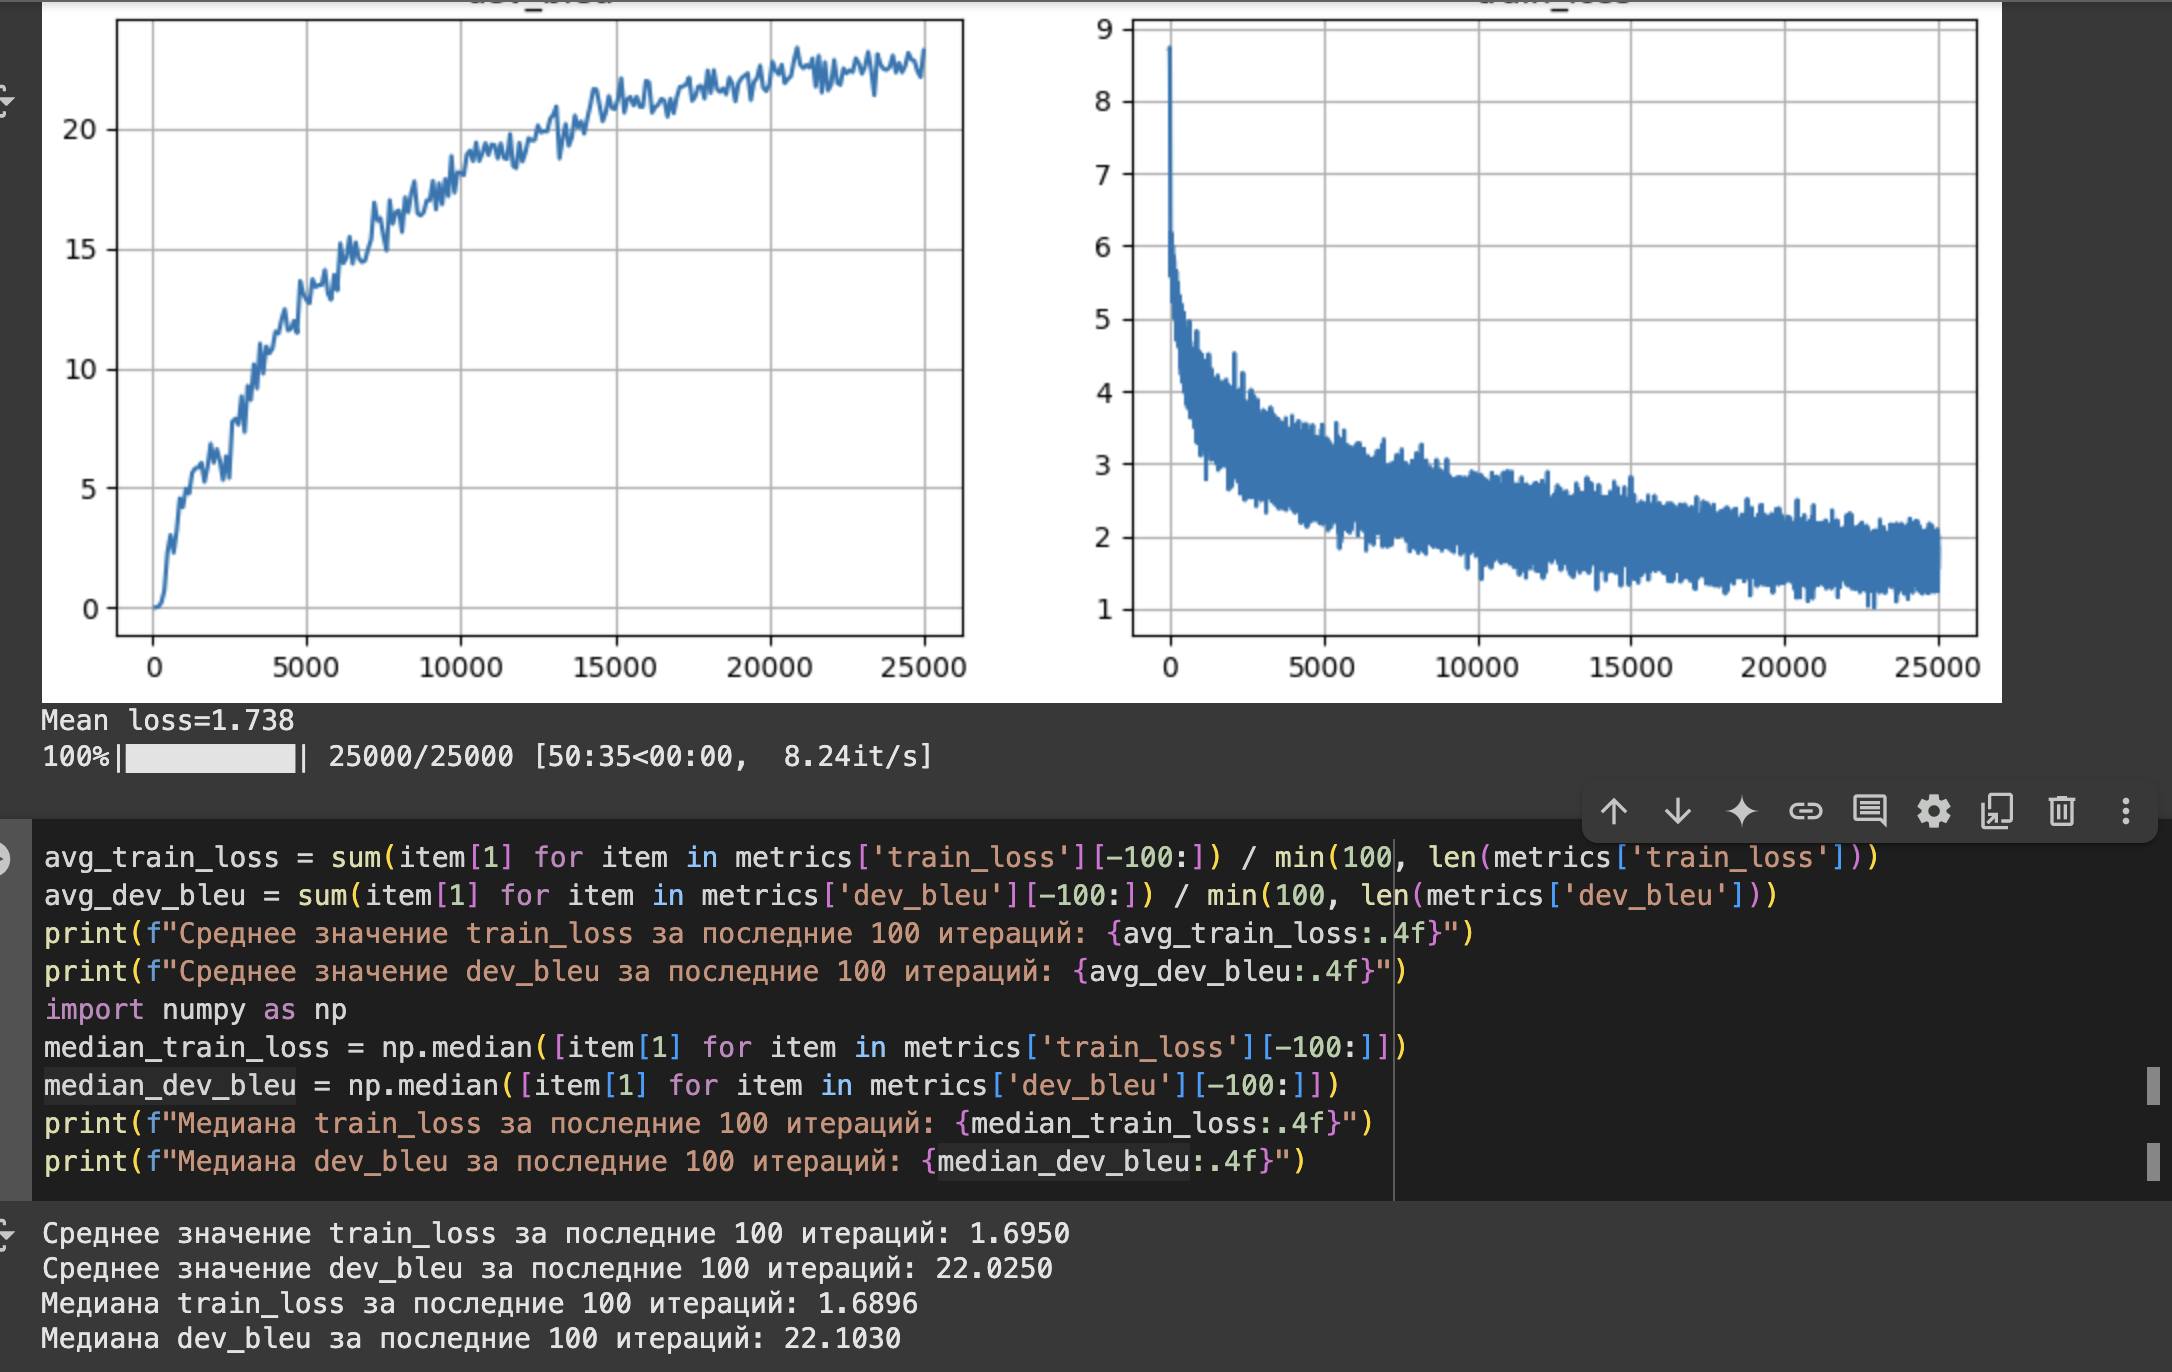

# 2 layer encoder + dropout + batch 128 for speed


---



In [9]:
class TwoLayerLSTMModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128, dropout=0.3):
        """ Translation model that uses attention with 2 layers and dropout. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        # Добавляем 2 слоя LSTM с dropout 0.3 между слоями
        self.enc0 = nn.LSTM(
            emb_size,
            hid_size,
            num_layers=2,  # 2 слоя
            dropout=dropout,  # Добавляем dropout между слоями
            batch_first=True
        )

        # Добавляем dropout слой для выходов декодера
        self.dropout = nn.Dropout(dropout)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.LSTMCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)

    def encode(self, inp, **flags):
        """
        Takes input sequences, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)

        # Запускаем энкодер (теперь с 2 слоями)
        enc_seq, (all_hidden, all_cell) = self.enc0(inp_emb)
        # all_hidden и all_cell имеют форму [num_layers, batch, hid_size]

        # Используем последний слой энкодера для инициализации декодера
        last_layer_hidden = all_hidden[-1]  # [batch, hid_size]

        # Для определения последних реальных токенов
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]

        dec_start = self.dec_start(last_state)
        cell_start = torch.zeros_like(dec_start)

        # apply attention layer from initial decoder hidden state
        inp_mask = self.out_voc.compute_mask(inp)
        attn, attn_probs = self.attention(enc_seq, dec_start, inp_mask)

        first_state = [(dec_start, cell_start), enc_seq, inp_mask, attn_probs]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        # Распаковываем кортеж (hidden, cell)
        (prev_hidden, prev_cell), enc_seq, enc_mask, _ = prev_state

        # Используем только hidden для attention
        attn, attn_probs = self.attention(enc_seq, prev_hidden, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)

        # LSTMCell возвращает кортеж (new_hidden, new_cell)
        new_hidden, new_cell = self.dec0(x, (prev_hidden, prev_cell))

        # Применяем dropout к hidden state перед использованием для логитов
        dropped_hidden = self.dropout(new_hidden)

        # Сохраняем оба состояния
        new_dec_state = [(new_hidden, new_cell), enc_seq, enc_mask, attn_probs]

        # Для генерации логитов используем hidden с применённым dropout
        output_logits = self.logits(dropped_hidden)

        return new_dec_state, output_logits

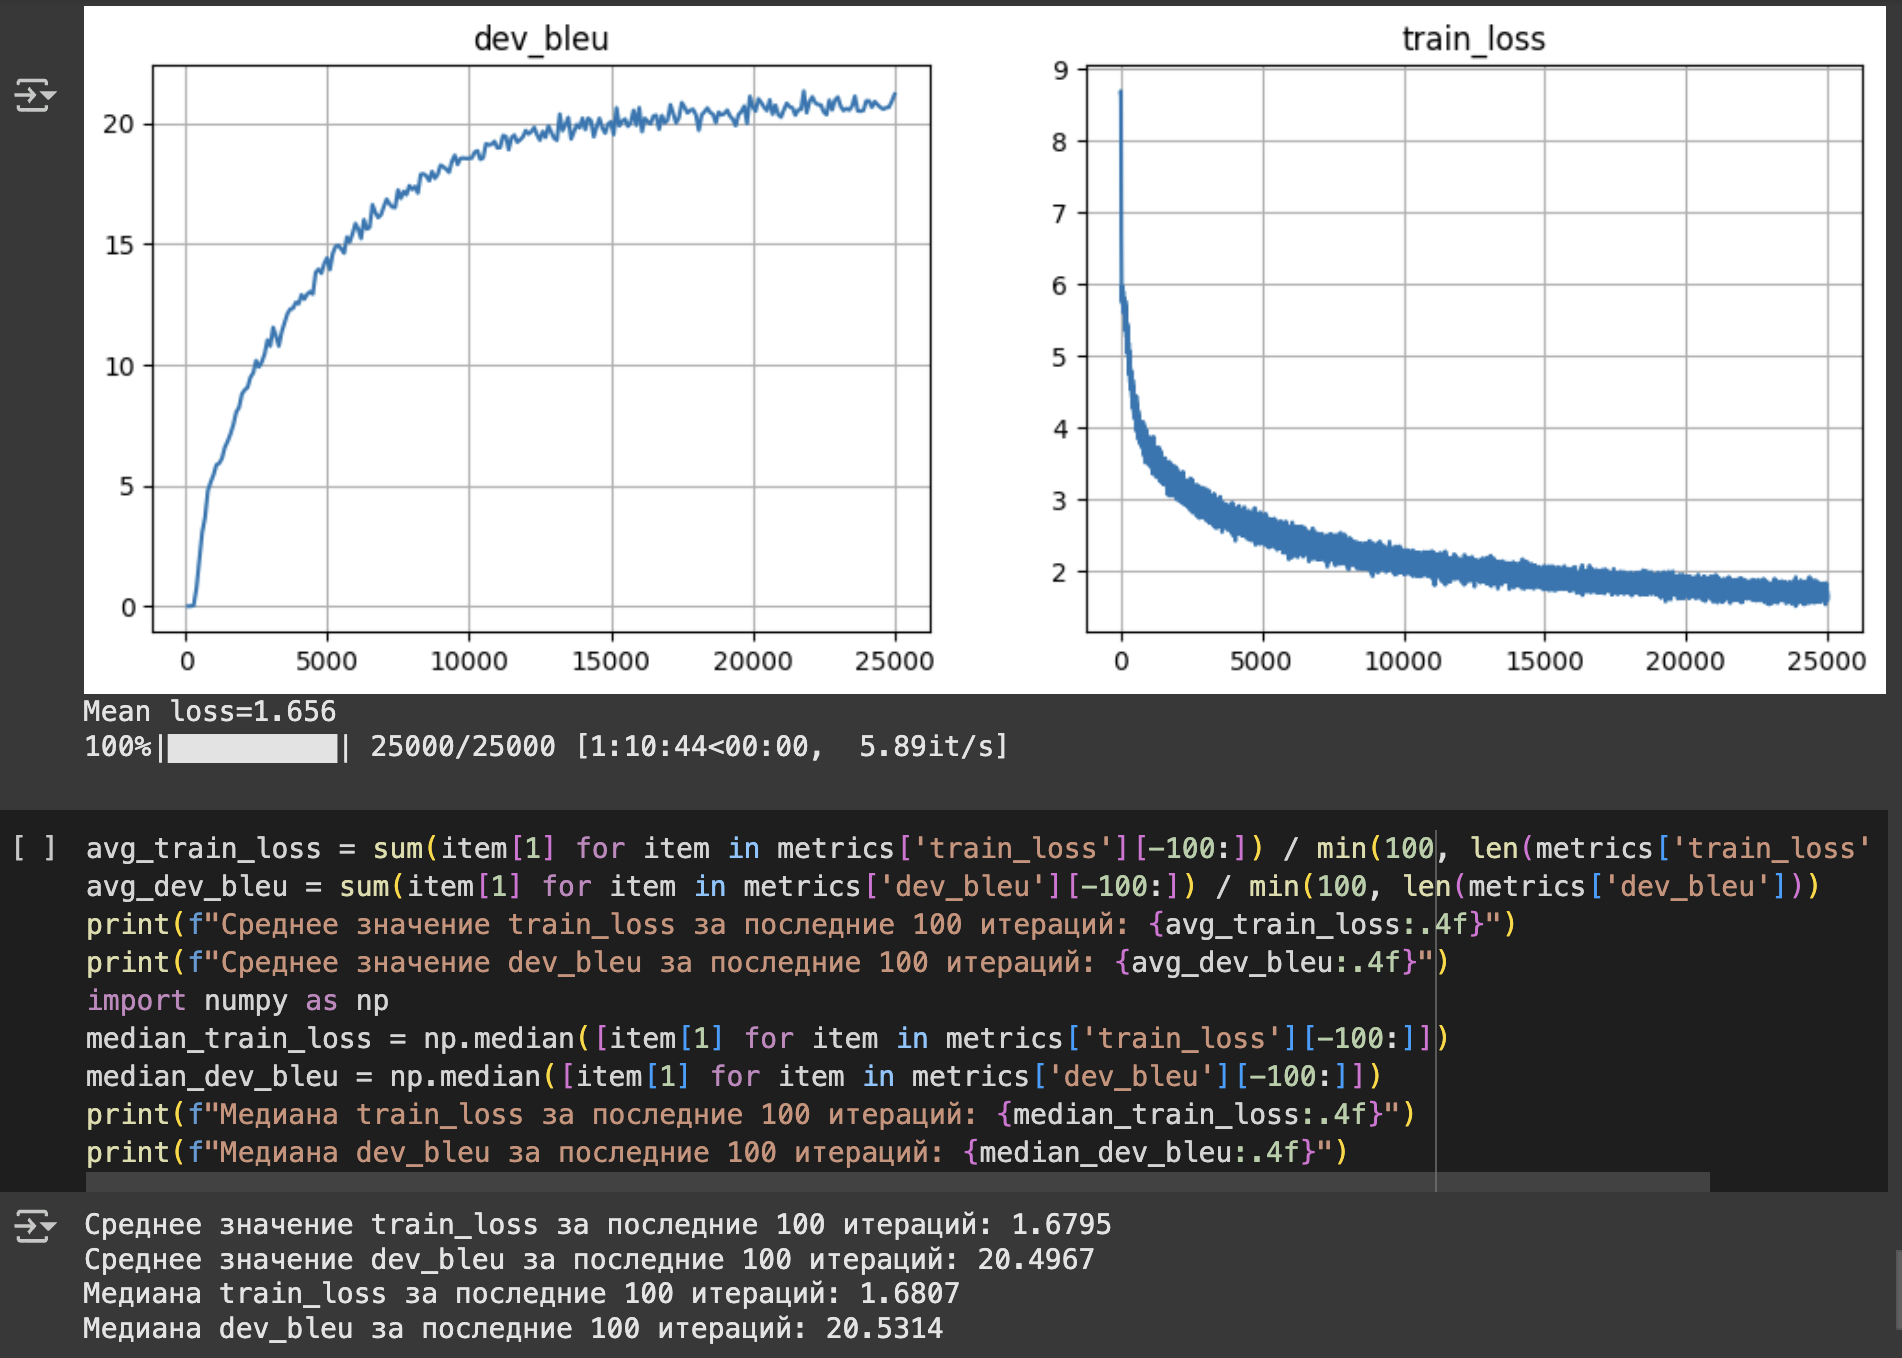

# Bidirectional

In [18]:
class BidirectionalLSTMModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128,
                bidirectional=True, num_layers=2, dropout=0.3):
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        # Encoder с настраиваемыми параметрами
        self.enc0 = nn.LSTM(
            emb_size,
            hid_size // 2 if bidirectional else hid_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )

        self.dropout_layer = nn.Dropout(dropout)

        self.dec_start = nn.Linear(hid_size, hid_size)
        # Декодер работает с полным размером скрытого состояния
        self.dec0 = nn.LSTMCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)

    def encode(self, inp, **flags):
        inp_emb = self.emb_inp(inp)

        # Запускаем bidirectional энкодер
        enc_seq, (hidden, cell) = self.enc0(inp_emb)

        # Находим реальные длины последовательностей (до EOS)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)

        # Вариант 1: Берем последние реальные состояния из последовательности
        last_states = enc_seq[torch.arange(len(enc_seq)), lengths]

        # Вариант 2: Также можем объединить прямое и обратное состояния
        # В двунаправленной модели forward_hidden содержит состояние после последнего токена
        # backward_hidden содержит состояние после первого токена
        # Используем индексацию для получения правильных состояний
        batch_size = inp.shape[0]
        forward_hidden = hidden[0]  # [batch_size, hidden_size//2]
        backward_hidden = hidden[1]  # [batch_size, hidden_size//2]

        # Объединяем состояния
        combined_hidden = torch.cat([forward_hidden, backward_hidden], dim=1)

        # Используем правильное состояние для инициализации декодера
        dec_start = self.dec_start(last_states)  # или используйте combined_hidden
        cell_start = torch.zeros_like(dec_start)

        # Применяем механизм внимания
        inp_mask = self.out_voc.compute_mask(inp)
        attn, attn_probs = self.attention(enc_seq, dec_start, inp_mask)

        first_state = [(dec_start, cell_start), enc_seq, inp_mask, attn_probs]
        return first_state


    def decode_step(self, prev_state, prev_tokens, **flags):
        # Распаковываем кортеж (hidden, cell)
        (prev_hidden, prev_cell), enc_seq, enc_mask, _ = prev_state

        # Используем только hidden для attention
        attn, attn_probs = self.attention(enc_seq, prev_hidden, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)

        # LSTMCell возвращает кортеж (new_hidden, new_cell)
        new_hidden, new_cell = self.dec0(x, (prev_hidden, prev_cell))

        # Сохраняем оба состояния
        new_dec_state = [(new_hidden, new_cell), enc_seq, enc_mask, attn_probs]

        # Для генерации логитов используем только hidden
        output_logits = self.logits(new_hidden)

        return new_dec_state, output_logits

    def decode_inference(self, initial_state, max_len=100, decoding_strategy='greedy', temperature=1.0, **flags):
        """
        Generate translations from model with different decoding strategies
        decoding_strategy: 'greedy', 'sample', or 'top_k_sample'
        temperature: controls randomness in sampling (lower = less random)
        """
        # Получаем batch_size и device из hidden_state
        (hidden_state, _), *_ = initial_state
        batch_size, device = hidden_state.size(0), hidden_state.device

        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])

            # Выбор стратегии декодирования
            if decoding_strategy == 'greedy':
                # Жадный выбор - берем токен с максимальной вероятностью
                next_token = logits.argmax(dim=-1)

            elif decoding_strategy == 'sample':
                # Сэмплирование из распределения с температурой
                probs = F.softmax(logits / temperature, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).squeeze(-1)

            elif decoding_strategy == 'top_k_sample':
                # Top-k сэмплирование (отбираем top_k наиболее вероятных токенов)
                k = 5  # можно передавать как параметр
                top_k_logits, top_k_indices = torch.topk(logits, k, dim=-1)
                top_k_probs = F.softmax(top_k_logits / temperature, dim=-1)

                # Сэмплируем из top-k
                sample_indices = torch.multinomial(top_k_probs, num_samples=1).squeeze(-1)
                next_token = torch.gather(top_k_indices, -1, sample_indices.unsqueeze(-1)).squeeze(-1)

            else:
                raise ValueError(f"Unknown decoding strategy: {decoding_strategy}")

            outputs.append(next_token)
            all_states.append(state)

            # Останавливаемся, если все последовательности закончились
            if (outputs[-1] == self.out_voc.eos_ix).all():
                break

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, decoding_strategy='greedy', temperature=1.0, **kwargs):
        device = next(self.parameters()).device
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(
            initial_state,
            decoding_strategy=decoding_strategy,
            temperature=temperature,
            **kwargs
        )
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

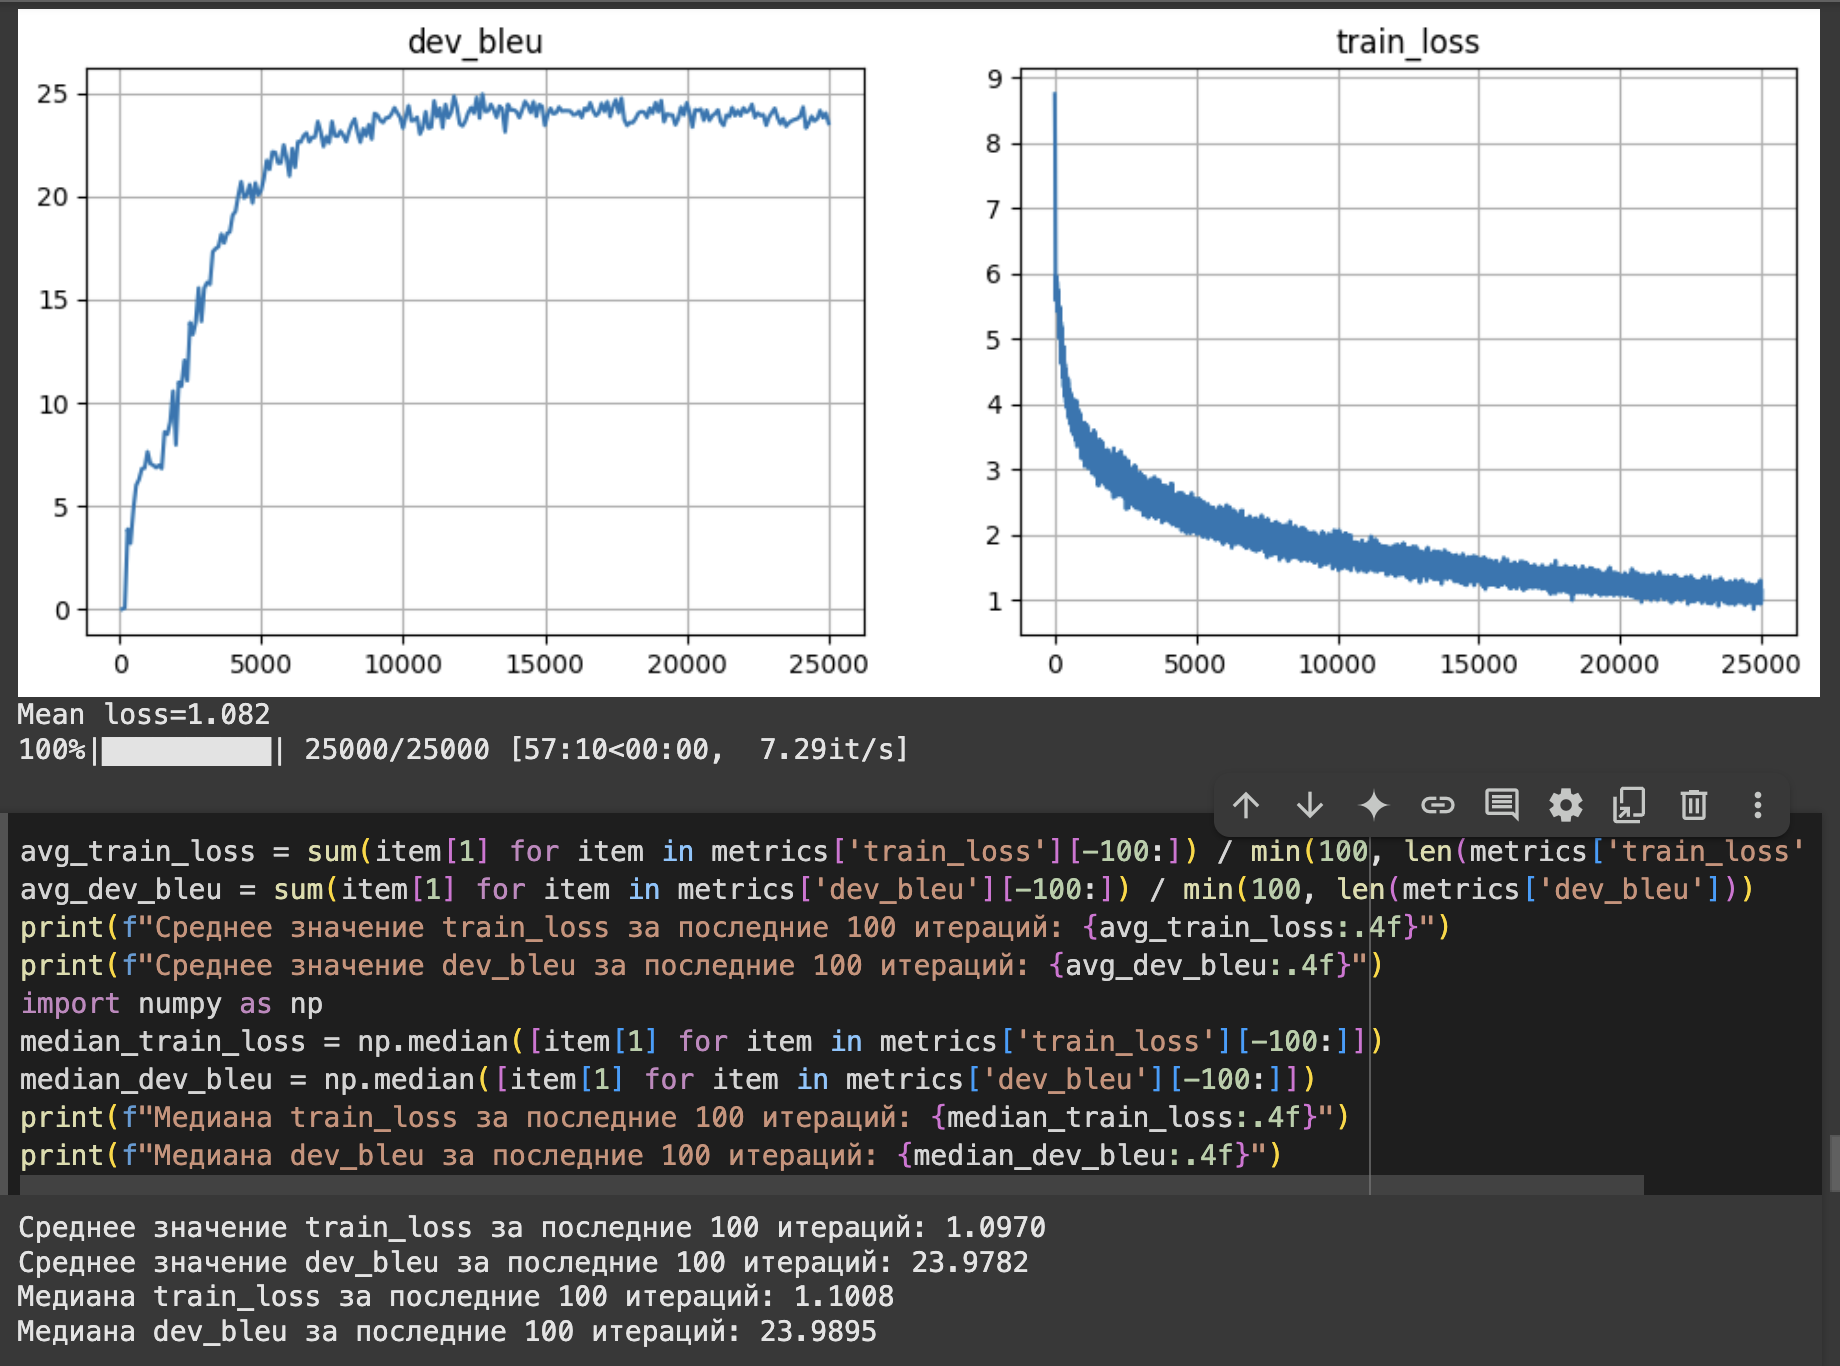

# bidirectional + improved training process + top k sampling



In [12]:
def compute_bleu(model, inp_lines, out_lines, decoding_strategy='greedy', temperature=1.0, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(
            inp_lines,
            decoding_strategy=decoding_strategy,
            temperature=temperature,
            **flags
        )
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

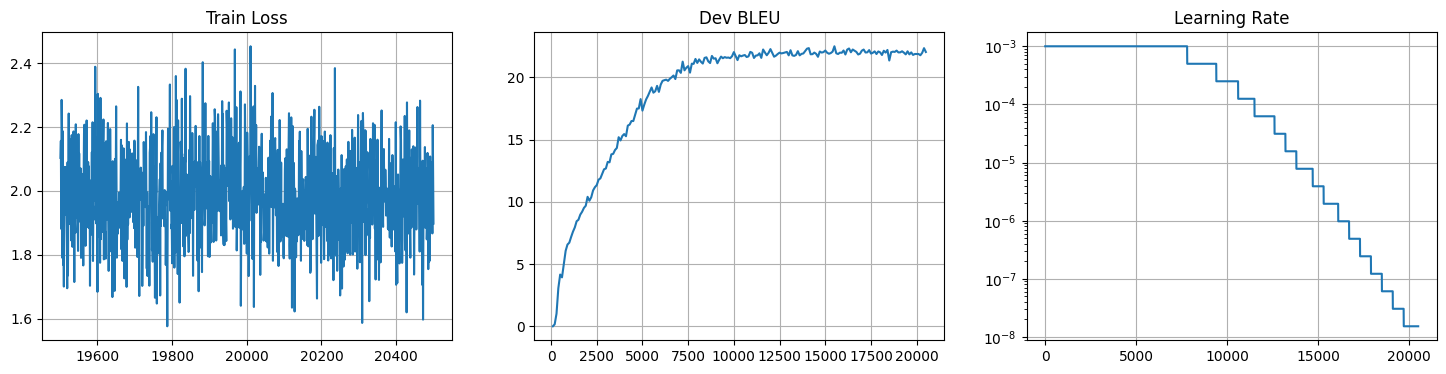

 82%|████████▏ | 20500/25000 [42:27<09:19,  8.05it/s]

Step: 20500, Loss: 2.0000, BLEU: 22.03, LR: 0.000000
Early stopping triggered!


In [13]:
metrics = {'train_loss': [], 'dev_bleu': []}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = BidirectionalLSTMModel(inp_voc, out_voc).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode='max', factor=0.5, patience=5, verbose=True
)

# Параметры
batch_size = 64
patience = 50
best_bleu = 0
no_improvement_count = 0
early_stop = False

# Сохраняем историю learning rate
lr_history = []

for _ in trange(25000):
    if early_stop:
        print("Early stopping triggered!")
        break

    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    opt.step()

    # Сохраняем текущий learning rate
    current_lr = opt.param_groups[0]['lr']
    lr_history.append((step, current_lr))

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
    # Можете использовать любую стратегию для оценки: 'greedy', 'sample', 'top_k_sample'
        current_bleu = compute_bleu(model, dev_inp, dev_out, decoding_strategy='top_k_sample', temperature=0.5)
        metrics['dev_bleu'].append((step, current_bleu))

        # Обновление scheduler
        scheduler.step(current_bleu)

        # Проверка для early stopping
        if current_bleu > best_bleu:
            best_bleu = current_bleu
            no_improvement_count = 0
            # Сохранение лучшей модели
            torch.save({
                'model': model.state_dict(),
                'optimizer': opt.state_dict(),
                'scheduler': scheduler.state_dict(),
                'step': step,
                'bleu': current_bleu
            }, 'best_model.pt')
            print(f"New best model saved! BLEU: {current_bleu:.2f}")
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                early_stop = True
                print(f"No improvement for {patience} evaluations. Best BLEU: {best_bleu:.2f}")

        # Визуализация
        clear_output(True)
        plt.figure(figsize=(18, 4))

        # Графики метрик
        plt.subplot(1, 3, 1)
        plt.title('Train Loss')
        plt.plot(*zip(*metrics['train_loss'][-1000:]))
        plt.grid()

        plt.subplot(1, 3, 2)
        plt.title('Dev BLEU')
        plt.plot(*zip(*metrics['dev_bleu']))
        plt.grid()

        # График learning rate
        plt.subplot(1, 3, 3)
        plt.title('Learning Rate')
        plt.plot(*zip(*lr_history))
        plt.yscale('log')
        plt.grid()

        plt.show()

        print(f"Step: {step}, Loss: {np.mean(metrics['train_loss'][-10:], axis=0)[1]:.4f}, "
              f"BLEU: {current_bleu:.2f}, LR: {current_lr:.6f}")

In [17]:
avg_train_loss = sum(item[1] for item in metrics['train_loss'][-100:]) / min(100, len(metrics['train_loss']))
avg_dev_bleu = sum(item[1] for item in metrics['dev_bleu'][-100:]) / min(100, len(metrics['dev_bleu']))
print(f"Среднее значение train_loss за последние 100 итераций: {avg_train_loss:.4f}")
print(f"Среднее значение dev_bleu за последние 100 итераций: {avg_dev_bleu:.4f}")
import numpy as np
median_train_loss = np.median([item[1] for item in metrics['train_loss'][-100:]])
median_dev_bleu = np.median([item[1] for item in metrics['dev_bleu'][-100:]])
print(f"Медиана train_loss за последние 100 итераций: {median_train_loss:.4f}")
print(f"Медиана dev_bleu за последние 100 итераций: {median_dev_bleu:.4f}")

Среднее значение train_loss за последние 100 итераций: 1.9746
Среднее значение dev_bleu за последние 100 итераций: 21.9652
Медиана train_loss за последние 100 итераций: 1.9695
Медиана dev_bleu за последние 100 итераций: 21.9797


# Abalation

In [20]:
def run_ablation_study(train_steps=1000, eval_steps=5):
    """Быстрое исследование влияния различных компонентов модели"""
    results = {}

    # Конфигурации моделей для сравнения
    configs = {
        'bidirectional': {'bidirectional': True, 'num_layers': 2, 'dropout': 0.3},
        'unidirectional': {'bidirectional': False, 'num_layers': 2, 'dropout': 0.3},
        'single_layer': {'bidirectional': True, 'num_layers': 1, 'dropout': 0.3},
        'no_dropout': {'bidirectional': True, 'num_layers': 2, 'dropout': 0.0}
    }

    # Стратегии декодирования для сравнения
    decode_strategies = ['greedy', 'sample', 'top_k_sample']

    for config_name, params in configs.items():
        print(f"Training model: {config_name}")

        # Создаем модель с текущей конфигурацией
        model = BidirectionalLSTMModel(
            inp_voc, out_voc,
            emb_size=64,
            hid_size=128,
            attn_size=128,
            bidirectional=params['bidirectional'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        ).to(device)

        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

        # Быстрое обучение
        for step in range(train_steps):
            batch_ix = np.random.randint(len(train_inp), size=32)
            batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
            batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

            optimizer.zero_grad()
            loss = compute_loss(model, batch_inp, batch_out)
            loss.backward()
            optimizer.step()

            if step % 100 == 0:
                print(f"Step {step}, Loss: {loss.item():.4f}")

        # Оценка модели с разными стратегиями декодирования
        bleu_scores = {}
        for strategy in decode_strategies:
            bleu = compute_bleu(
                model,
                dev_inp[:100],  # Используем только часть dev данных для скорости
                dev_out[:100],
                decoding_strategy=strategy,
                temperature=0.8 if strategy != 'greedy' else 1.0
            )
            bleu_scores[strategy] = bleu
            print(f"{config_name} + {strategy}: BLEU = {bleu:.2f}")

        results[config_name] = bleu_scores

    # Вывод результатов в виде таблицы
    print("\n=== ABLATION STUDY RESULTS ===")
    header = ["Model"] + decode_strategies
    print(" | ".join(header))
    print("-" * (sum(len(h) for h in header) + 3 * (len(header) - 1)))

    for model_name, scores in results.items():
        row = [model_name] + [f"{scores[s]:.2f}" for s in decode_strategies]
        print(" | ".join(row))

    return results

# Запуск исследования
ablation_results = run_ablation_study(train_steps=4000, eval_steps=5)

Training model: bidirectional
Step 0, Loss: 8.7117
Step 100, Loss: 5.4769
Step 200, Loss: 5.4418
Step 300, Loss: 5.0137
Step 400, Loss: 4.7984
Step 500, Loss: 4.5024
Step 600, Loss: 4.1953
Step 700, Loss: 3.8921
Step 800, Loss: 3.9198
Step 900, Loss: 4.0382
Step 1000, Loss: 4.1141
Step 1100, Loss: 3.6511
Step 1200, Loss: 3.3695
Step 1300, Loss: 3.7300
Step 1400, Loss: 3.4679
Step 1500, Loss: 3.4586
Step 1600, Loss: 3.5407
Step 1700, Loss: 3.2077
Step 1800, Loss: 3.5623
Step 1900, Loss: 3.4071
Step 2000, Loss: 3.3492
Step 2100, Loss: 3.2815
Step 2200, Loss: 3.2527
Step 2300, Loss: 3.2903
Step 2400, Loss: 2.8904
Step 2500, Loss: 3.3402
Step 2600, Loss: 3.2885
Step 2700, Loss: 3.0934
Step 2800, Loss: 3.4439
Step 2900, Loss: 2.9038
Step 3000, Loss: 3.3319
Step 3100, Loss: 3.1053
Step 3200, Loss: 3.2813
Step 3300, Loss: 2.8608
Step 3400, Loss: 3.7492
Step 3500, Loss: 2.8614
Step 3600, Loss: 3.2513
Step 3700, Loss: 3.0042
Step 3800, Loss: 3.4131
Step 3900, Loss: 2.7281
bidirectional + greedy